# Fatality Predictor - Noetbook 1 - Préparation et Feature Engineering

## Partie I - Introduction

#### Contexte et Problématique

Les accidents de la route constituent un enjeu majeur de sécurité publique, avec des conséquences humaines et économiques considérables. L’objectif de ce projet est de développer un modèle de machine learning capable de prédire la gravité d'un accident, à savoir l'état de l'usager le plus accidenté (mort, blessé grave ou autre).

Une telle prédiction pourrait permettre d’identifier les situations à haut risque et d’optimiser les politiques de prévention routière.

Le défi principal réside dans la nature des données disponibles : celles-ci sont réparties sur quatre jeux de données distincts contenant des informations complémentaires, mais qui ne peuvent pas être fusionnées directement.

L’enjeu est donc de concevoir une approche qui exploite au mieux ces informations pour construire des features robustes et pertinentes.

#### Description des Données

Les données sont structurées en quatre jeux distincts :

1. Caractéristiques des accidents : Ce dataset contient des informations générales sur chaque accident, comme la date, l’heure, les conditions météorologiques, la luminosité, et la configuration de la route.

2.	Lieux des accidents : Il détaille l’emplacement des accidents (région, type d’environnement, etc.).

3.	Véhicules impliqués : Ce fichier répertorie les caractéristiques des véhicules présents dans chaque accident (type de véhicule, ancienneté, état du véhicule, etc.).

4.	Usagers impliqués : Ce fichier contient des informations sur les conducteurs et passagers impliqués dans chaque accident (âge, sexe, gravité des blessures, rôle dans l’accident).

Chaque accident possède un ID unique, mais un même accident peut impliquer plusieurs véhicules et plusieurs usagers. Il est donc impossible de fusionner directement ces jeux de données en une seule table sans perdre de l’information.

Il va donc falloir transformer ces données multi-source en un format exploitable pour l’entraînement de modèles prédictifs.

#### Plan

Nous avons découpé le travail en deux notebooks :

- Notebook 1 (celui-ci) : Nettoyage, exploration, transformation et feature engineering des données pour produire un dataset final prêt pour l’entraînement.

- Notebook 2 : Modélisation et évaluation du modèle de prédiction.

## Partie II - Importation et Exploration des Données

Nous commençons par importer les bibliothèques et charger les jeux de données.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

path = "/Users/sachaabitbol/Desktop/Projet Ramp SMS/"

df_caracteristiques = pd.read_csv(path + "caracteristiques_clean.csv")
df_lieux            = pd.read_csv(path + "lieux_clean.csv")
df_vehicules        = pd.read_csv(path + "vehicules_clean.csv")
df_usagers          = pd.read_csv(path + "usagers_clean.csv")

Puis, nous nous assurerons que nos jeux de données sont propres.

In [2]:
def clean_dataframe(df):
    
    # Suppression des colonnes avec plus de 30% de NaN
    missing_percent = df.isna().mean()
    cols_to_drop = missing_percent[missing_percent > 0.3].index
    df = df.drop(columns=cols_to_drop)

    # Suppression des lignes contenant au moins un NaN
    df = df.dropna()

    # Suppression des doublons
    df.drop_duplicates(inplace=True)
    
    return df

df_caracteristiques = clean_dataframe(df_caracteristiques)
df_lieux = clean_dataframe(df_lieux)
df_vehicules = clean_dataframe(df_vehicules)
df_usagers = clean_dataframe(df_usagers)

Nous analysons alors les distributions des variables catégoriques et numériques pour mieux comprendre les données.


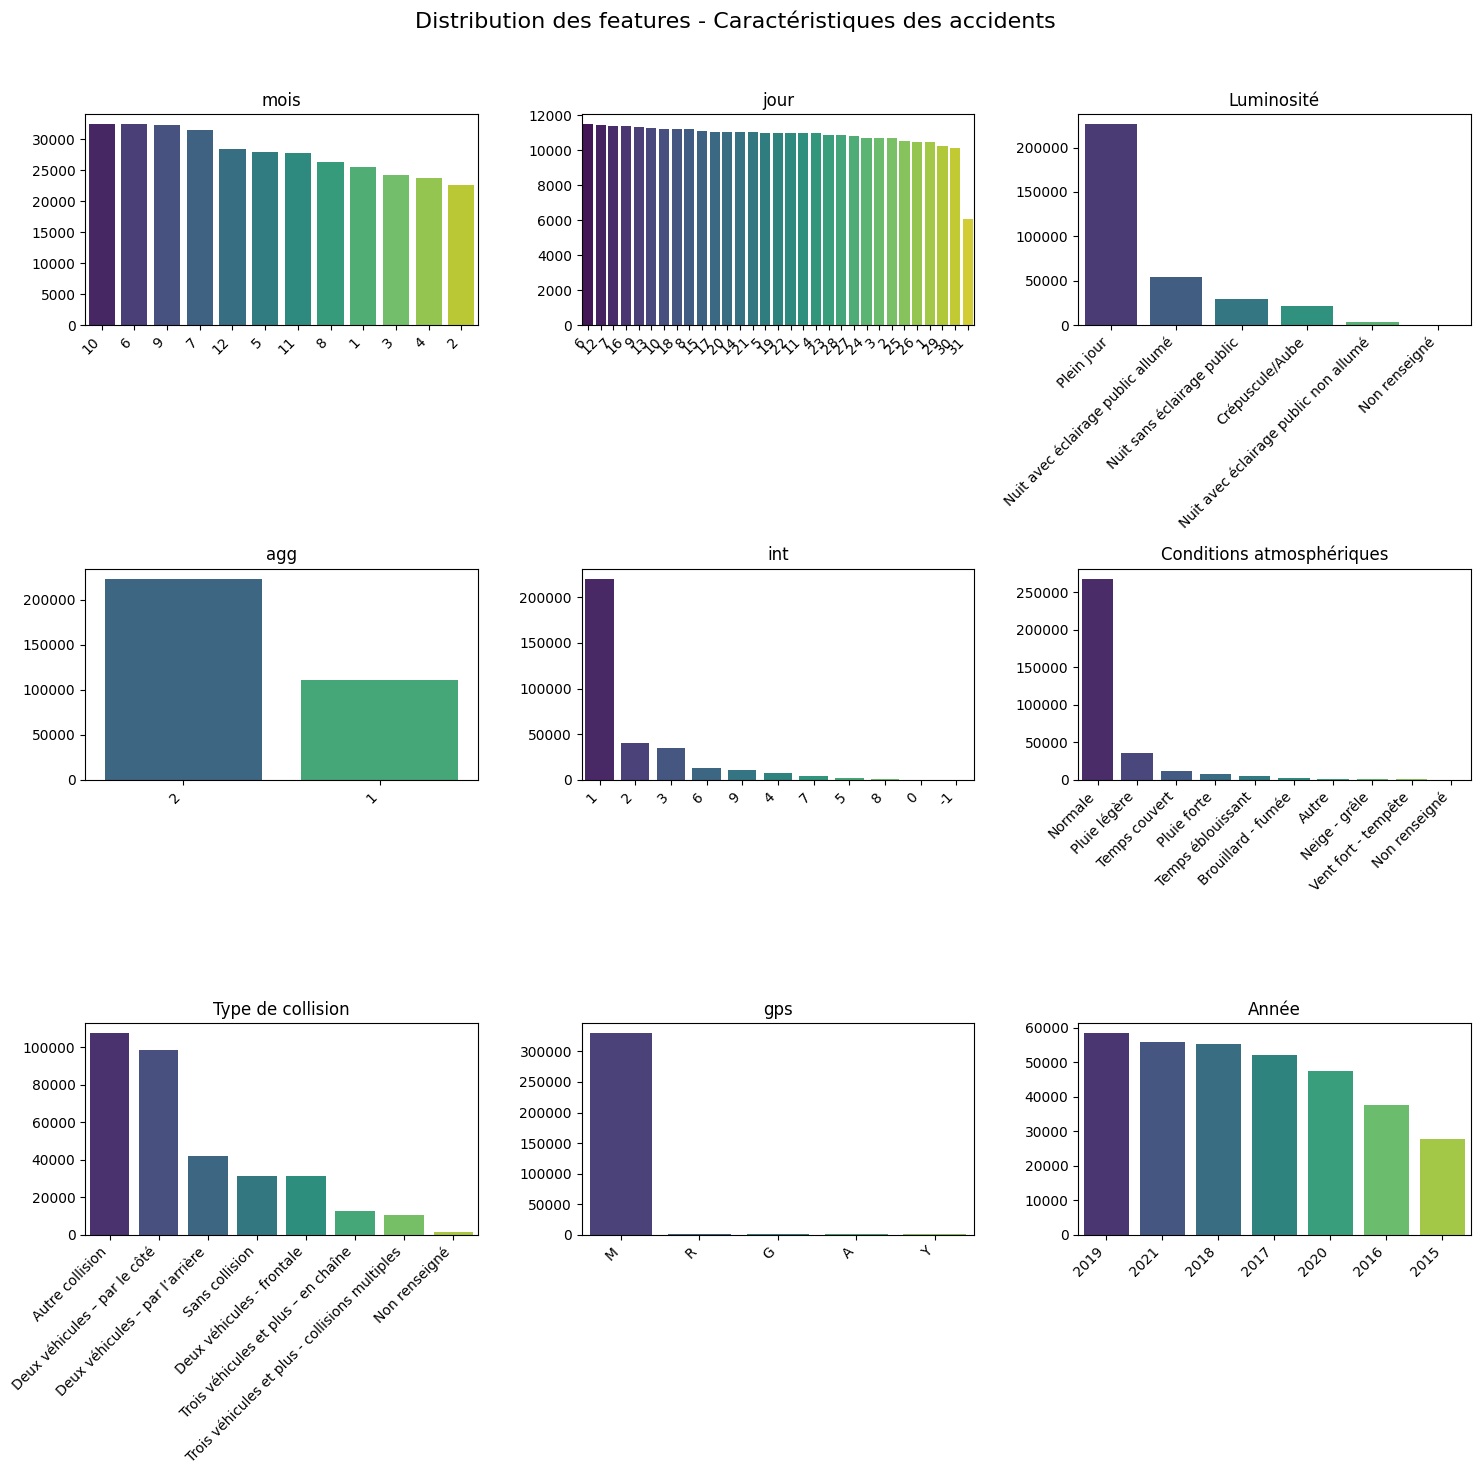

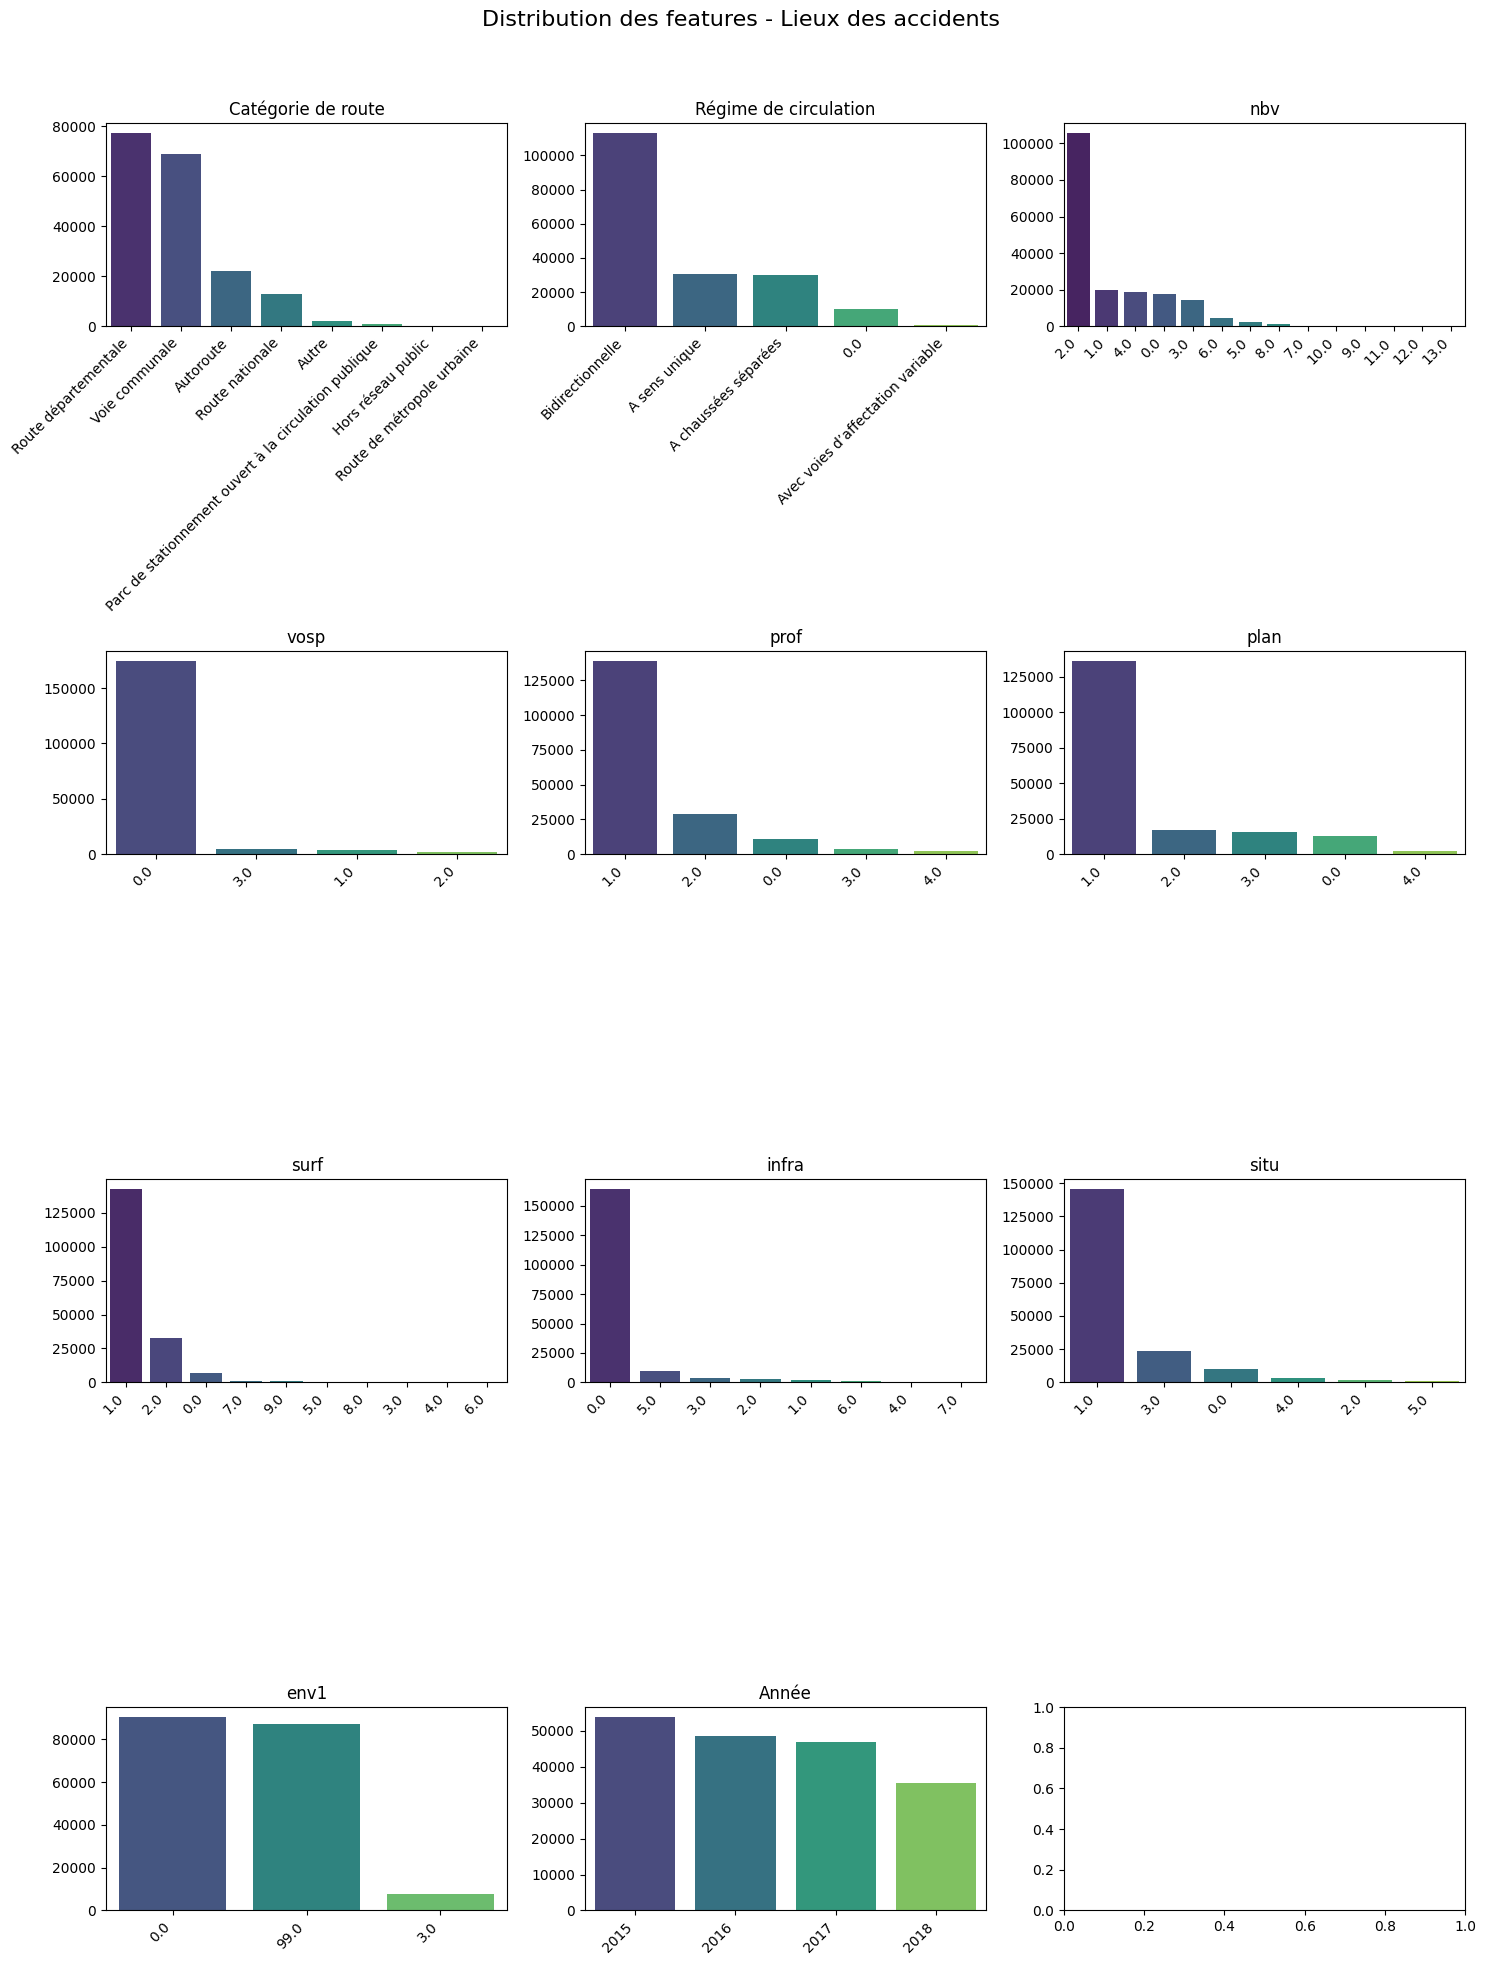

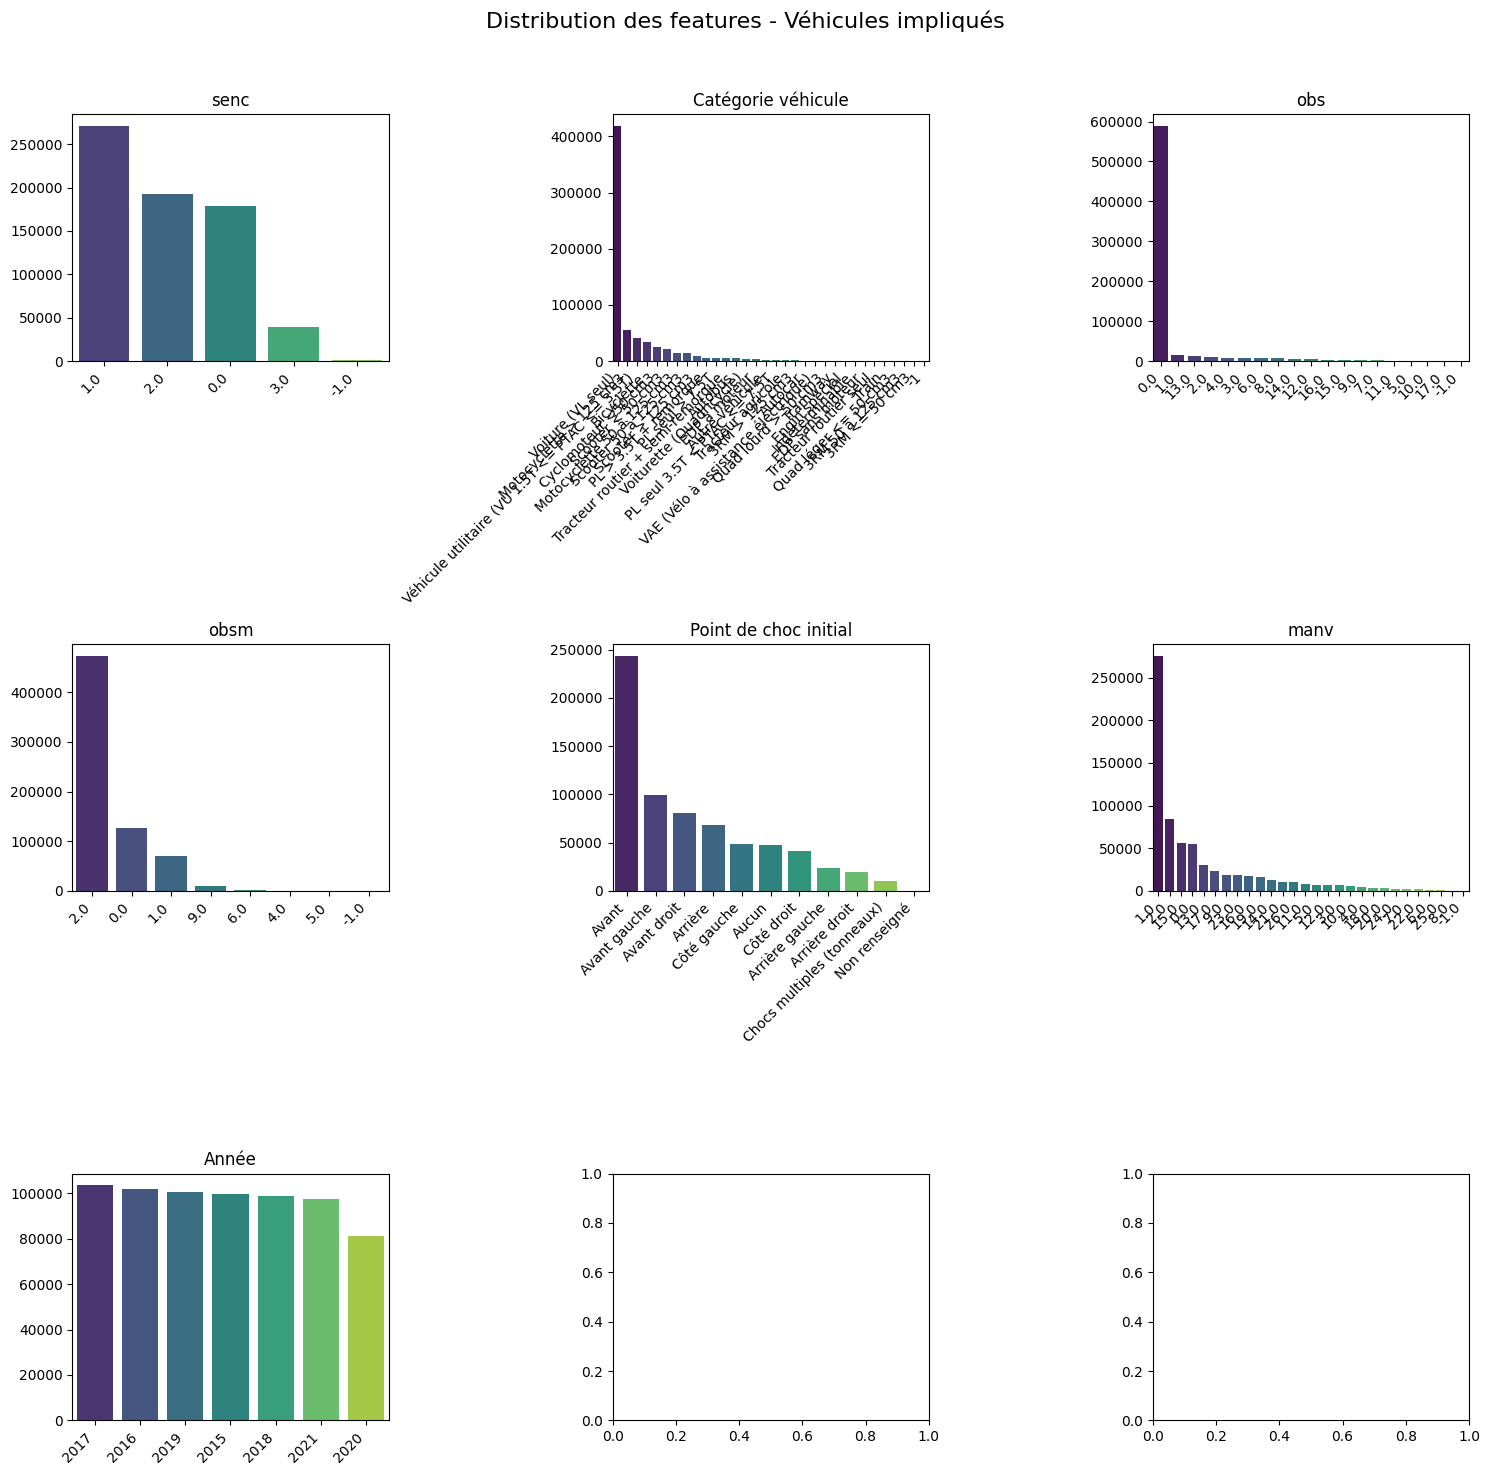

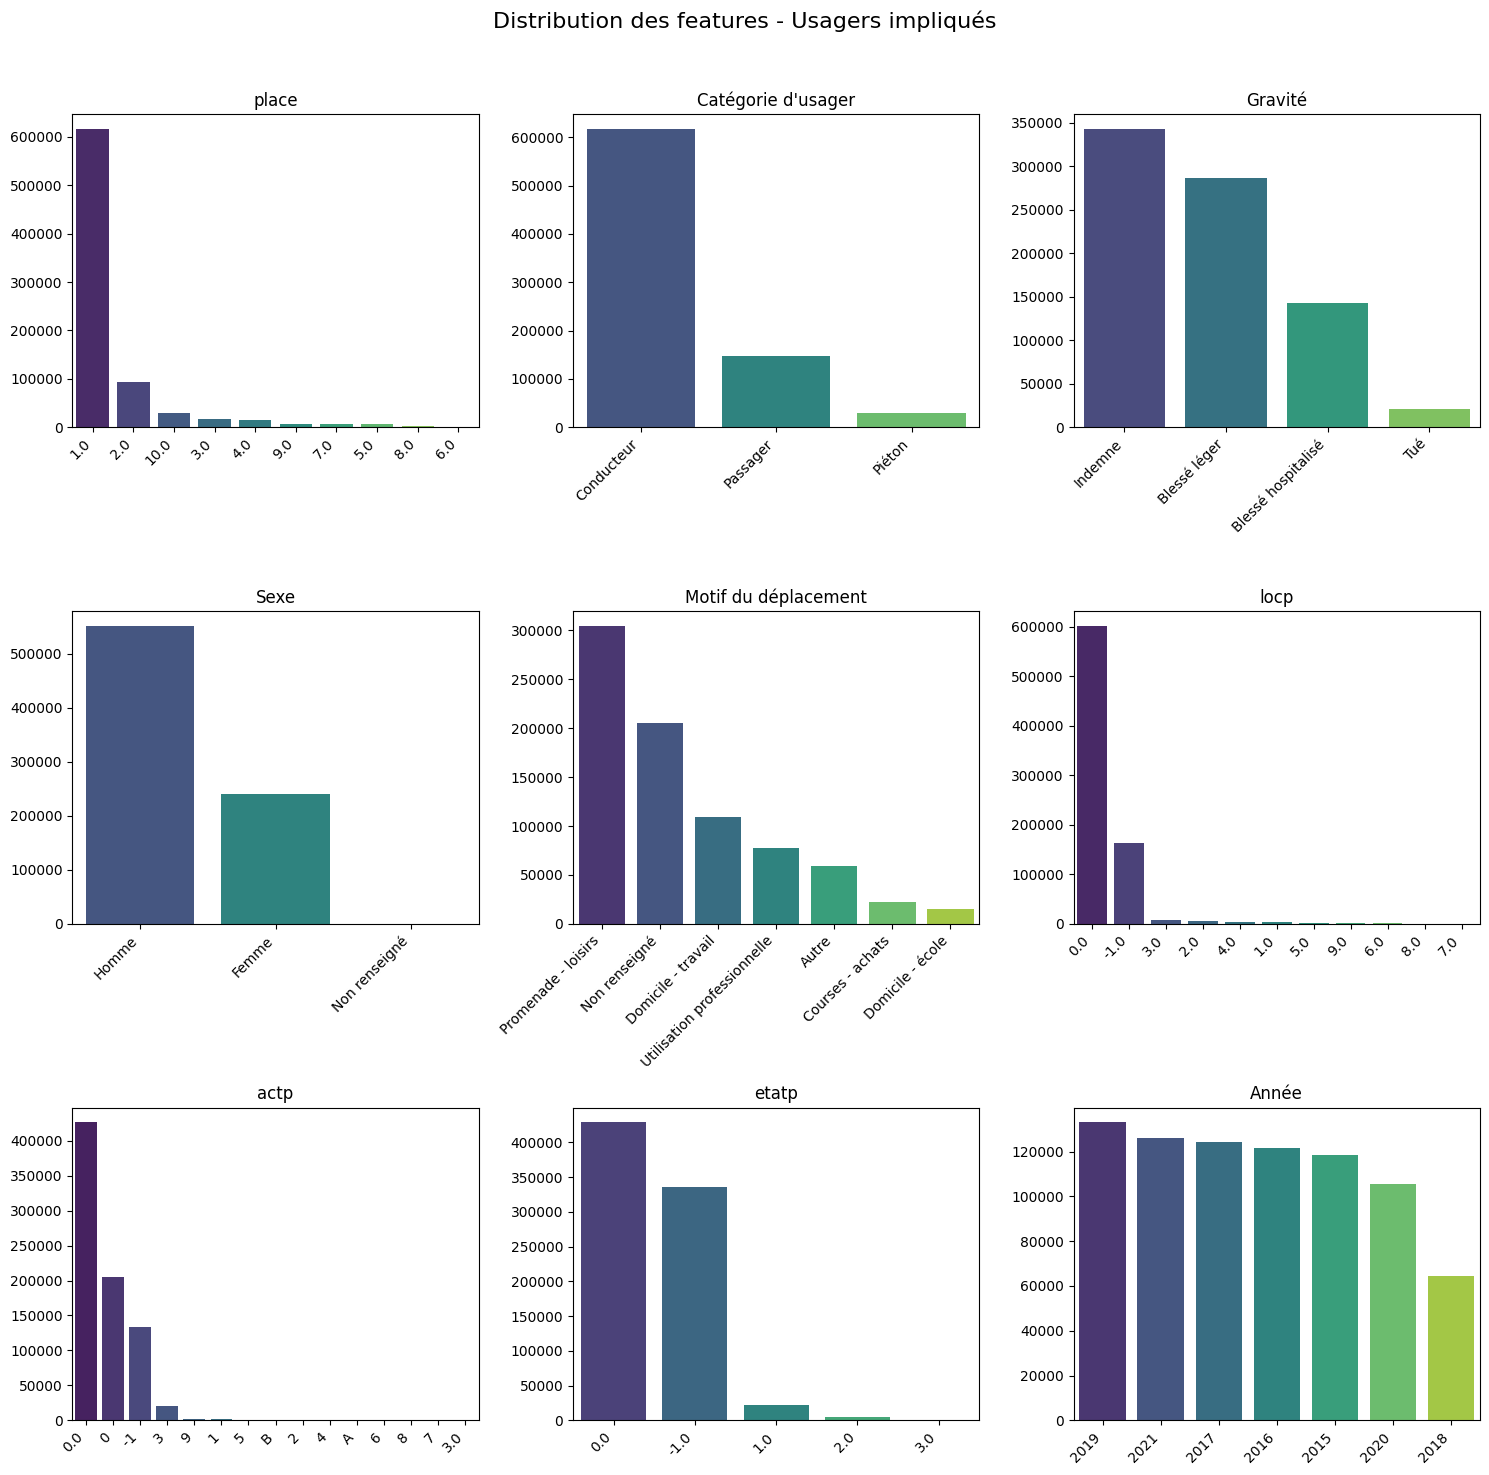

In [3]:
def plot_distributions(df, dataset_name, max_categories=50):
    
    features = [col for col in df.columns if df[col].nunique() <= max_categories]

    if not features:
        return

    num_cols = len(features)
    num_rows = math.ceil(num_cols / 3)

    fig, axes = plt.subplots(num_rows, min(3, num_cols), figsize=(15, 5 * num_rows))
    fig.suptitle(f"Distribution des features - {dataset_name}", fontsize=16)
    axes = axes.flatten() if num_cols > 1 else [axes]

    for i, col in enumerate(features):
        
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i], palette="viridis")
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")
        axes[i].set_title(f"{col}")
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

datasets = {"Caractéristiques des accidents": df_caracteristiques,
            "Lieux des accidents": df_lieux,
            "Véhicules impliqués": df_vehicules,
            "Usagers impliqués": df_usagers}

for dataset_name, df in datasets.items():
    plot_distributions(df, dataset_name)

## Partie III - Sélection et Transformation des Données

Dans cette section, nous allons supprimer des colonnes non pertinentes, filtrer certaines catégories dans les variables catégoriques et transformer certaines valeurs pour réduire la cardinalité des catégories. Ces transformations visent à réduire le bruit dans nos données et à mieux structurer les features avant la modélisation.

#### III.1 - Caractéristiques accidents

Nous allons :

- Supprimer la colonne "gps".

- Ajouter des colonnes "Jour_semaine" et "Saison" : utilisation de datetime pour extraire ces informations à partir de mois, jour et Année, puis suppression des colonnes "mois", "jour" et "Année"

- Ne selectionner que les conditions atmosphériques importantes.

- Encoder de la colonne “Luminosité” : nous créons deux nouvelles colonnes binaires et supprimons l’ancienne.

- Ajouter la colonne "Moment_journee" et supprimer hrmn.

In [4]:
df_caracteristiques.drop(columns=["gps"], inplace=True)

def get_day_of_week(year, month, day):
    return datetime.date(year, month, day).weekday()

df_caracteristiques["Jour_semaine"] = df_caracteristiques.apply(lambda row: get_day_of_week(row["Année"], row["mois"], row["jour"]), axis=1)

def get_season(month):
    if month in [12, 1, 2]:
        return "Hiver"
    elif month in [3, 4, 5]:
        return "Printemps"
    elif month in [6, 7, 8]:
        return "Été"
    else:
        return "Automne"
    
df_caracteristiques["Saison"] = df_caracteristiques["mois"].apply(get_season)

df_caracteristiques.drop(columns=["mois", "jour", "Année"], inplace=True)

conditions_valides = ["Normale", "Pluie légère", "Temps couvert", "Pluie forte"]
df_caracteristiques = df_caracteristiques[df_caracteristiques["Conditions atmosphériques"].isin(conditions_valides)]

def encode_luminosite(lumi):
    if lumi == "Plein jour":
        return "Plein jour"
    elif lumi == "Nuit avec éclairage public allumé":
        return "Nuit éclairée"
    else:
        return "Nuit sans éclairage"

df_caracteristiques["Luminosité_Catégorie"] = df_caracteristiques["Luminosité"].apply(encode_luminosite)
df_caracteristiques["Plein_jour"] = df_caracteristiques["Luminosité_Catégorie"] == "Plein jour"
df_caracteristiques["Nuit_éclairée"] = df_caracteristiques["Luminosité_Catégorie"] == "Nuit éclairée"

df_caracteristiques.drop(columns=["Luminosité", "Luminosité_Catégorie"], inplace=True)

def categorize_hour(heure):
    if heure >= 6 and heure < 9:
        return 1  # Matin tôt
    elif heure >= 9 and heure < 19:
        return 2  # Pleine journée
    elif heure >= 19 and heure < 22:
        return 3  # Soirée
    else:
        return 4  # Pleine nuit

df_caracteristiques["hrmn"] = df_caracteristiques["hrmn"].astype(str)
df_caracteristiques["heure"] = df_caracteristiques["hrmn"].str[:2].astype(int)
df_caracteristiques["Moment_journee"] = df_caracteristiques["heure"].apply(categorize_hour)
df_caracteristiques.drop(columns=["hrmn", "heure"], inplace=True)

print("Caractéristiques des accidents :", df_caracteristiques.shape, "\n")
print(df_caracteristiques.head())

Caractéristiques des accidents : (323210, 16) 

   Unnamed: 0  Numéro d'accident  agg  int Conditions atmosphériques  \
0      721900       201500000001    2    1                   Normale   
1      721901       201500000002    2    1                   Normale   
2      721902       201500000003    2    1                   Normale   
3      721903       201500000004    2    1                   Normale   
4      721904       201500000005    2    1                   Normale   

                Type de collision  com                     adr        lat  \
0    Deux véhicules – par le côté   52       54 RUE GHESQUIERE        0.0   
1       Deux véhicules - frontale  670  25, rue anatole france  5054878.0   
2  Deux véhicules – par l’arrière   11           RUE NATIOANLE        0.0   
3       Deux véhicules - frontale  477  rue Camille Desmoulins        0.0   
4                 Autre collision   52     113, rue Ghesquière        0.0   

       long  dep  Jour_semaine   Saison  Plein_jour  Nui

#### III.2 - Lieux des accidents

Nous allons :

- Supprimer les colonnes inutiles

- Regrouper les entre elles les catégories de route, celles de régime de criculation, celles de nombre de voie.

- Traiter la présence ou non d'un obtsacle.

In [5]:
df_lieux.drop(columns=["voie", "vosp", "prof", "plan", "surf", "infra", "Année"], inplace=True)

def categorize_road(road):

    if road == "Route départementale":
        return "D"
    elif road == "Autoroute":
        return "A"
    elif road == "Route nationale":
        return "N"
    else:
        return "C"
    
df_lieux["Catégorie de route"] = df_lieux["Catégorie de route"].apply(categorize_road)

regime_valides = ["Bidirectionnelle", "A sens unique", "A chaussées séparées"]
df_lieux = df_lieux[df_lieux["Régime de circulation"].isin(regime_valides)]

df_lieux["nbv"] = df_lieux["nbv"].apply(lambda x: -1 if x < 2.0 else 0 if x == 2 else 1)

df_lieux["Obstacle"] = df_lieux["env1"] == 99.0
df_lieux.drop(columns=["env1"], inplace=True)

print("Lieux des accidents :", df_lieux.shape, "\n")
print(df_lieux.head())

Lieux des accidents : (173922, 7) 

   Unnamed: 0  Numéro d'accident Catégorie de route Régime de circulation  \
0      721900       201500000001                  D      Bidirectionnelle   
1      721901       201500000002                  D      Bidirectionnelle   
2      721902       201500000003                  D      Bidirectionnelle   
3      721903       201500000004                  C      Bidirectionnelle   
4      721904       201500000005                  D      Bidirectionnelle   

   nbv  situ  Obstacle  
0    0   1.0     False  
1    0   1.0      True  
2   -1   1.0      True  
3   -1   1.0      True  
4   -1   1.0      True  


#### III.3 - Véhicules impliqués

Nous allons:

- Supprimer la colonne "Année".

- Regrouper les catégories de véhicules et celles des types de collision.

In [6]:
df_vehicules.drop(columns=["Année"], inplace=True)

def simplify_vehicle_category(category):
    if "cyclette" in category or "scooter" in category:
        return "Deux-roues"
    elif "Véhicule utilitaire" in category:
        return "Utilitaire"
    elif category == "Voiture (VL seul)":
        return "Voiture"
    else:
        return "Autre"

df_vehicules["Catégorie véhicule"] = df_vehicules["Catégorie véhicule"].apply(simplify_vehicle_category)
df_vehicules = df_vehicules[df_vehicules["Catégorie véhicule"] != "Autre"]

def categorize_collision(point):
    if "Avant" in point:
        return "Avant"
    elif "Arrière" in point:
        return "Arrière"
    elif "Côté" in point:
        return "Côté"
    else:
        return "Multiples"

df_vehicules["Point_de_choc"] = df_vehicules["Point de choc initial"].apply(categorize_collision)
df_vehicules.drop(columns=["Point de choc initial"], inplace=True)

print("Véhicules impliqués :", df_vehicules.shape, "\n")
print(df_vehicules.head())

Véhicules impliqués : (566125, 9) 

   Unnamed: 0  Numéro d'accident  senc Catégorie véhicule  obs  obsm  manv  \
0     1231688       201500000001   0.0         Deux-roues  0.0   2.0   1.0   
1     1231689       201500000001   0.0            Voiture  0.0   2.0  20.0   
3     1231691       201500000002   0.0            Voiture  0.0   2.0  23.0   
5     1231693       201500000003   0.0            Voiture  0.0   2.0   1.0   
6     1231694       201500000004   0.0            Voiture  0.0   2.0   1.0   

  num_veh Point_de_choc  
0     A01         Avant  
1     B02       Arrière  
3     B02         Avant  
5     A01       Arrière  
6     A01         Avant  


#### III.4 - Usagers impliqués

Nous allons :

- Supprimer les colonnes "locp", "etatp", "actp" et "Motif de déplacement"

- Encoder la colonne "place".

- Créer les features “Mort” et “Blessé Grave” (nous distinguons les accidents mortels et les blessures graves) et supprimer la colonne Gravité.

- Considerer que lorsque le sexe n'est pas mentionné, il s'agit d'un homme, car ils sont surreprésentés dans les accidents de la route.

- Calculer l'âge des usagers puis supprimer les colonnes "Année" et "an_nais".

In [7]:
df_usagers.drop(columns=["locp", "etatp", "actp", "Motif du déplacement"], inplace=True)

df_usagers["place"] = df_usagers["place"].apply(lambda x: True if x == 1.0 else False)

df_usagers["Mort"] = df_usagers["Gravité"] == "Tué"
df_usagers["Blessé_Grave"] = df_usagers["Gravité"] == "Blessé hospitalisé"
df_usagers.drop(columns=["Gravité"], inplace=True)

df_usagers["Sexe"] = df_usagers["Sexe"].apply(lambda x: x if x in ["Homme", "Femme"] else "Homme")

df_usagers["âge"] = df_usagers["Année"] - df_usagers["an_nais"]
df_usagers.drop(columns=["an_nais", "Année"], inplace=True)

print("Usagers impliqués :", df_usagers.shape, "\n")
print(df_usagers.head())

Usagers impliqués : (792856, 9) 

   Unnamed: 0  Numéro d'accident  place Catégorie d'usager   Sexe num_veh  \
0     1612206       2.015000e+11   True         Conducteur  Homme     A01   
1     1612207       2.015000e+11   True         Conducteur  Homme     B02   
2     1612208       2.015000e+11   True         Conducteur  Homme     A01   
3     1612209       2.015000e+11   True         Conducteur  Femme     B02   
4     1612210       2.015000e+11   True         Conducteur  Homme     B02   

    Mort  Blessé_Grave   âge  
0  False          True  29.0  
1  False         False  62.0  
2  False          True  16.0  
3  False         False  50.0  
4  False          True  17.0  


#### III.5 - Harmonisation des Accidents entre les Différents Datasets

Avec toutes les actions de filtrage et de transformation effectuées, nous avons supprimé certains accidents de chaque dataset. Cependant, ces suppressions ne sont pas uniformes : un accident peut être présent dans un dataset mais absent d’un autre.

Nous devons maintenant nous assurer que chaque accident apparaisse dans les 4 datasets. Nous supprimons donc tous les accidents qui ne sont pas présents dans l’ensemble des 4 datasets.


In [8]:
accidents_caracteristiques = set(df_caracteristiques["Numéro d'accident"])
accidents_lieux            = set(df_lieux["Numéro d'accident"])
accidents_vehicules        = set(df_vehicules["Numéro d'accident"])
accidents_usagers          = set(df_usagers["Numéro d'accident"])

accidents_communs = accidents_caracteristiques & accidents_lieux & accidents_vehicules & accidents_usagers

df_caracteristiques = df_caracteristiques[df_caracteristiques["Numéro d'accident"].isin(accidents_communs)]
df_lieux            = df_lieux[df_lieux["Numéro d'accident"].isin(accidents_communs)]
df_vehicules        = df_vehicules[df_vehicules["Numéro d'accident"].isin(accidents_communs)]
df_usagers          = df_usagers[df_usagers["Numéro d'accident"].isin(accidents_communs)]

print(f"Nouvelles tailles des datasets :\n")
print(f"    Caractéristiques des accidents : {df_caracteristiques.shape}")
print(f"    Lieux des accidents : {df_lieux.shape}")
print(f"    Véhicules impliqués : {df_vehicules.shape}")
print(f"    Usagers impliqués : {df_usagers.shape}")

Nouvelles tailles des datasets :

    Caractéristiques des accidents : (95974, 16)
    Lieux des accidents : (95974, 7)
    Véhicules impliqués : (151025, 9)
    Usagers impliqués : (207461, 9)


Nous pouvons maintenant fusionner df_caracteristiques et df_lieux, car ces deux datasets contiennent des informations au niveau de l’accident (1 ligne par accident).

Dans ce nouveau dataset, nous allons également ajouter deux colonnes : une colonne contenant la liste des ID des véhicules impliqués dans chaque accident et une colonne contenant la liste des ID des usagers impliqués dans chaque accident.

Cela permet d’avoir un accès rapide aux véhicules et usagers associés à chaque accident, sans fusionner directement ces datasets.

In [9]:
# Fusion des datasets df_caracteristiques et df_lieux sur la colonne "Numéro d'accident"
df_accidents = df_caracteristiques.merge(df_lieux, on="Numéro d'accident", how="inner")


# Ajout des colonnes avec les listes d’ID des véhicules et usagers
df_vehicules_grouped = df_vehicules.groupby("Numéro d'accident")["Unnamed: 0"].apply(list).reset_index()
df_vehicules_grouped.rename(columns={"Unnamed: 0": "Liste_ID_Vehicules"}, inplace=True)

df_usagers_grouped = df_usagers.groupby("Numéro d'accident")["Unnamed: 0"].apply(list).reset_index()
df_usagers_grouped.rename(columns={"Unnamed: 0": "Liste_ID_Usagers"}, inplace=True)

df_accidents = df_accidents.merge(df_vehicules_grouped, on="Numéro d'accident", how="left")
df_accidents = df_accidents.merge(df_usagers_grouped, on="Numéro d'accident", how="left")


# Supression des dernières colonnes à présent inutiles pour notre modélisation
df_accidents.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y", "adr", "lat", "long"], inplace=True)
df_vehicules.drop(columns=["Unnamed: 0", "num_veh"], inplace=True)
df_usagers.drop(columns=["Unnamed: 0", "num_veh"], inplace=True)

In [10]:
print("Accidents :", df_accidents.shape, "\n")
print(df_accidents.head())

print("\nVéhicules impliqués :", df_vehicules.shape, "\n")
print(df_vehicules.head())

print("\nUsagers impliqués :", df_usagers.shape, "\n")
print(df_usagers.head())

Accidents : (95974, 19) 

   Numéro d'accident  agg  int Conditions atmosphériques  \
0       201500000001    2    1                   Normale   
1       201500000002    2    1                   Normale   
2       201500000003    2    1                   Normale   
3       201500000004    2    1                   Normale   
4       201500000005    2    1                   Normale   

                Type de collision  com  dep  Jour_semaine   Saison  \
0    Deux véhicules – par le côté   52  590             1    Hiver   
1       Deux véhicules - frontale  670  590             5      Été   
2  Deux véhicules – par l’arrière   11  590             2      Été   
3       Deux véhicules - frontale  477  590             2      Été   
4                 Autre collision   52  590             4  Automne   

   Plein_jour  Nuit_éclairée  Moment_journee Catégorie de route  \
0        True          False               2                  D   
1        True          False               3              

#### III.6 - Exploration des Valeurs Uniques de Chaque Colonne

Afin de mieux comprendre les variables restantes dans chaque dataset, nous allons lister toutes les valeurs uniques présentes dans chaque colonne (en excluant les colonnes contenant des listes). Cela nous permettra d’identifier les différentes modalités des variables catégoriques, l’étendue des valeurs numériques discrètes et les éventuelles valeurs erronées ou incohérentes.

In [11]:
def display_unique_values(df, dataset_name):
    
    print(f"\n{dataset_name} - Valeurs uniques par colonne :\n")
    
    for col in df.columns:

        # On vérifie si la colonne contient des listes
        if df[col].apply(lambda x: isinstance(x, list)).any():
            continue
        
        unique_values = df[col].dropna().astype(str).unique()
        
        if len(unique_values) > 15:
            print(f"{col} : {list(unique_values[:3])} ... ({len(unique_values)} valeurs uniques)")
        else:
            print(f"{col} : {list(unique_values)}")

display_unique_values(df_accidents, "Accidents")
display_unique_values(df_vehicules, "Véhicules impliqués")
display_unique_values(df_usagers, "Usagers impliqués")


Accidents - Valeurs uniques par colonne :

Numéro d'accident : ['201500000001', '201500000002', '201500000003'] ... (95974 valeurs uniques)
agg : ['2', '1']
int : ['1', '3', '2', '5', '9', '6', '7', '8', '4', '0']
Conditions atmosphériques : ['Normale', 'Pluie légère', 'Pluie forte', 'Temps couvert']
Type de collision : ['Deux véhicules – par le côté', 'Deux véhicules - frontale', 'Deux véhicules – par l’arrière', 'Autre collision', 'Sans collision', 'Trois véhicules et plus - collisions multiples', 'Trois véhicules et plus – en chaîne']
com : ['52', '670', '11'] ... (847 valeurs uniques)
dep : ['590', '620', '800'] ... (101 valeurs uniques)
Jour_semaine : ['1', '5', '2', '4', '0', '3', '6']
Saison : ['Hiver', 'Été', 'Automne', 'Printemps']
Plein_jour : ['True', 'False']
Nuit_éclairée : ['False', 'True']
Moment_journee : ['2', '3', '4', '1']
Catégorie de route : ['D', 'C', 'N', 'A']
Régime de circulation : ['Bidirectionnelle', 'A sens unique', 'A chaussées séparées']
nbv : ['0', '-1',

## Partie IV - Encodage et Feature Engineering

Dans cette partie, nous allons encoder les variables catégorielles et créer les dernières nouvelles features. Le dataset final généré servira d’entrée pour la modélisation dans le Notebook 2.

In [12]:
df_final = df_accidents.copy()

# Encodage des variables catégorielles

df_final["En_Agglomeration"] = df_final["agg"] == 2
df_final.drop(columns=["agg"], inplace=True)

df_final["Pluie"] = df_final["Conditions atmosphériques"].isin(["Pluie forte", "Pluie légère"])
df_final["Pluie_Forte"] = df_final["Conditions atmosphériques"] == "Pluie forte"
df_final["Temps_Couvert"] = df_final["Conditions atmosphériques"] == "Temps couvert"
df_final.drop(columns=["Conditions atmosphériques"], inplace=True)

df_final["Plus_de_2_Vehicules"] = df_final["Type de collision"].str.contains("Trois véhicules et plus", regex=True)
df_final.drop(columns=["Type de collision"], inplace=True)

df_final = pd.get_dummies(df_final, columns=["Saison"], drop_first=True)
df_final = pd.get_dummies(df_final, columns=["Moment_journee"], prefix="Moment", drop_first=True)
df_final = pd.get_dummies(df_final, columns=["Catégorie de route"], prefix="Route", drop_first=True)
df_final = pd.get_dummies(df_final, columns=["Régime de circulation"], prefix="Circulation", drop_first=True)

df_final["Nbv_Plus_2"] = df_final["nbv"] == 1
df_final["Nbv_Exact_2"] = df_final["nbv"] == 0
df_final.drop(columns=["nbv"], inplace=True)

In [13]:
# Gestion des véhicules (30s)

def extract_vehicle_info(accident_id):
    """ Fonction pour compter le nombre de véhicules et les chocs par type. """
    
    vehicules = df_vehicules[df_vehicules["Numéro d'accident"] == accident_id]
    
    if vehicules.empty:
        return pd.Series([0, 0, 0, 0, 0, 0])

    type_counts = vehicules["Catégorie véhicule"].value_counts()
    choc_counts = vehicules["Point_de_choc"].value_counts()

    return pd.Series([type_counts.get("Deux-roues", 0),
                      type_counts.get("Voiture", 0),
                      type_counts.get("Utilitaire", 0),
                      choc_counts.get("Avant", 0) + choc_counts.get("Multiples", 0),
                      choc_counts.get("Arrière", 0) + choc_counts.get("Multiples", 0),
                      choc_counts.get("Côté", 0) + choc_counts.get("Multiples", 0)])

df_final[["Nb_Deux_roues", "Nb_Voiture",
          "Nb_Utilitaire", "Nb_Choc_Avant",
          "Nb_Choc_Arriere", "Nb_Choc_Cote"]] = df_final["Numéro d'accident"].apply(extract_vehicle_info)

In [15]:
# Gestion des usagers (30s)

def extract_usager_info(accident_id):
    
    usagers = df_usagers[df_usagers["Numéro d'accident"] == accident_id]
    
    if usagers.empty:
        return pd.Series([0, 0, np.nan, np.nan, np.nan, 0, 0, 0, 0])

    total_morts = usagers["Mort"].sum()
    total_blesses_graves = usagers["Blessé_Grave"].sum()
    y = 2 * (total_morts > 0) + 1 * ((total_blesses_graves > 0) & (total_morts == 0))

    total_counts = usagers["Catégorie d'usager"].value_counts()
    total_sexe_counts = usagers["Sexe"].value_counts()

    return pd.Series([y, usagers["âge"].min(),
                      usagers["âge"].max(),
                      usagers["âge"].mean().round(1),
                      total_counts.get("Conducteur", 0),
                      total_counts.get("Passager", 0),
                      total_sexe_counts.get("Homme", 0),
                      total_sexe_counts.get("Femme", 0)])

# Mise à jour du dataset avec les nouvelles colonnes
df_final[["y", "Age_Min", "Age_Max", "Age_Moyen",
          "Nb_Conducteurs", "Nb_Passagers", "Nb_Hommes", "Nb_Femmes"]] = df_final["Numéro d'accident"].apply(extract_usager_info)

In [16]:
# Nettoyage final
df_final.drop(columns=["int", "com", "dep", "situ", "Liste_ID_Vehicules", "Liste_ID_Usagers"], inplace=True)

In [17]:
print("Dataset final prêt pour la modélisation :", df_final.shape, "\n")
print(df_final.head())
display_unique_values(df_final, "Dataset final")

Dataset final prêt pour la modélisation : (95974, 37) 

   Numéro d'accident  Jour_semaine  Plein_jour  Nuit_éclairée  Obstacle  \
0       201500000001             1        True          False     False   
1       201500000002             5        True          False      True   
2       201500000003             2        True          False      True   
3       201500000004             2        True          False      True   
4       201500000005             4        True          False      True   

   En_Agglomeration  Pluie  Pluie_Forte  Temps_Couvert  Plus_de_2_Vehicules  \
0              True  False        False          False                False   
1              True  False        False          False                False   
2              True  False        False          False                False   
3              True  False        False          False                False   
4              True  False        False          False                False   

   ...  Nb_Choc_Ar

## Partie V - Préparation des Données pour la Modélisation

Nous pouvons à présent préparer notre dataset final pour la modélisation. Cette étape consistera à :

- Définir la variable cible y, qui représente la gravité de l’accident : 2 si au moins un usager est décédé, 1 si au moins un usager est blessé grave mais aucun décès, 0 sinon.

- Diviser les données en ensembles d’entraînement et de test (80%-20%) et enregistrer ces datasets pour les utiliser dans le Notebook 2, dédié à la modélisation.

L’objectif est d’obtenir des fichiers structurés et prêts à être utilisés pour entraîner et évaluer notre modèle de prédiction de la gravité des accidents.

In [22]:
y = df_final["y"]
X = df_final.drop(columns=["y"])

print("Distribution de y:\n")
print(y.value_counts(normalize=True))

print("\nDivision en train et test...\n")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")

print("\nSauvegarde des fichiers CSV...")
X_train["y"] = y_train
X_train.to_csv(path + "X_train.csv", index=False)
X_test.to_csv(path + "X_test.csv", index=False)
y_test.to_csv(path + "y_test.csv", index=False)
print("Sauvegarde terminée !")

Distribution de y:

y
0.0    0.594755
1.0    0.349803
2.0    0.055442
Name: proportion, dtype: float64

Division en train et test...

X_train : (76779, 36), y_train : (76779,)
X_test : (19195, 36), y_test : (19195,)

Sauvegarde des fichiers CSV...
Sauvegarde terminée !
